<a href="https://colab.research.google.com/github/anryabtsev/TransportNet/blob/master/Project2_Mathematical_modeling_of_flow_networks_Ryabtsev.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Study of the rate of convergence of methods on average for the choice of the starting point.**

### **Experiment design:** we choose several  𝑅 , for each unique  𝑅  we generate random points from the sphere with radius  𝑅  and center in  𝑡∗ . Run experiments with different starting points and collect histories (trajectories) for certain number of iterations (equal for each method). Look at duality gap reduction in average.

# Packages installation

In [205]:
!pip install scanf

In [206]:
!echo "deb http://downloads.skewed.de/apt bionic main" >> /etc/apt/sources.list
!apt-key adv --keyserver keys.openpgp.org --recv-key 612DEFB798507F25
!apt-get update
!apt-get install python3-graph-tool python3-cairo python3-matplotlib

Executing: /tmp/apt-key-gpghome.069SX66YzZ/gpg.1.sh --keyserver keys.openpgp.org --recv-key 612DEFB798507F25
gpg: key 612DEFB798507F25: "Tiago de Paula Peixoto <tiago@skewed.de>" not changed
gpg: Total number processed: 1
gpg:              unchanged: 1
Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:5 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:8 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
H

# Imports

In [207]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [208]:
import os

os.chdir("/content/drive/MyDrive/TransportNet")

In [209]:
import pandas as pd
import numpy as np
import data_handler as dh
import model as md
import time
import json
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import rc
import seaborn as sns
import pickle
from scipy.stats import bernoulli

In [210]:
import numba
numba.__version__

'0.51.2'

In [211]:
import sys
print(sys.executable)
print(sys.version)
print(sys.version_info)
from platform import python_version
print('python', python_version())
print('numpy', np.__version__)
print('pandas', pd.__version__)
import graph_tool
print('graph_tool', graph_tool.__version__)

/usr/bin/python3
3.7.12 (default, Sep 10 2021, 00:21:48) 
[GCC 7.5.0]
sys.version_info(major=3, minor=7, micro=12, releaselevel='final', serial=0)
python 3.7.12
numpy 1.19.5
pandas 1.1.5
graph_tool 2.43 (commit 9d41331e, Wed Jul 7 15:32:52 2021 +0200)


# Start

## Plotting functions

In [243]:
def get_cmap(n, name='tab20'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)


def plot1(means, stds):
    """
    input: res["final_dg_means"], res["final_dg_stds"]
    """
    length = len(means)
    x_vals = np.linspace(1, length, length)

    plt.figure(figsize = (12, 6))
    plt.errorbar(x_vals, means, stds, linestyle='None', marker='^', label="Average duality gap with standard deviation")

    plt.legend(loc='best', fontsize=17)
    plt.title(f"Dependence of final duality gap on R for 5000 iterations", fontsize=15)
    plt.show()


def plot2(histories, normalized=False):
    """
    input: res["dg_histories"]
    """
    first_key = list(histories.keys())[0]
    length = len(histories[first_key][0])
    x_vals = np.linspace(1, length, length)

    cmap = get_cmap(len(histories))
    patches = []
    for i, color in enumerate(cmap.colors):
        patches.append(mpatches.Patch(color, color, label=f"R = {list(histories.keys())[i]}"))

    plt.figure(figsize = (14, 7))

    y_vals = np.mean(histories[first_key], 0)
    if normalized:
        y_vals = y_vals / y_vals[0]
        plt.loglog(x_vals, y_vals, 
                 c=cmap(0), label='duality gap reduction in average')
    else:
        plt.loglog(x_vals, y_vals, 
                    c=cmap(0), label='duality gap reduction in average')

    for i, key in enumerate(list(histories.keys())[1:]):

        y_vals = np.mean(histories[key], 0)
        if normalized:
            y_vals = y_vals / y_vals[0]
            plt.loglog(x_vals, y_vals, c=cmap(i+1))
        else:
            plt.loglog(x_vals, y_vals, c=cmap(i+1))
        
    plt.legend(loc='best', handles=patches, fontsize=17)
    if normalized:
        plt.title(f"Normalized duality gap convergence in average for different R (loglog)", fontsize=15)
    else:
        plt.title(f"Duality gap convergence in average for different R (loglog)", fontsize=15)

    plt.show()


def plot3(histories, normalized=False):
    """
    input: res["dg_histories"]
    """
    first_key = list(histories.keys())[0]
    length = len(histories[first_key][0])
    x_vals = np.linspace(1, length, length)

    cmap = get_cmap(len(histories))
    patches = []
    for i, color in enumerate(cmap.colors):
        patches.append(mpatches.Patch(color, color, label=f"R = {list(histories.keys())[i]}"))

    plt.figure(figsize = (14, 7))

    y_vals = np.mean(histories[first_key], 0)
    std_vals = np.std(histories[first_key], 0)
    if normalized:
        std_vals = std_vals / y_vals[0]
        y_vals = y_vals / y_vals[0]

    plt.semilogx(x_vals, y_vals, 
                 c=cmap(0), label='duality gap reduction in average')
    plt.fill_between(x_vals, 
                     y_vals - std_vals, 
                     y_vals + std_vals,
                     color=cmap(0), alpha=0.2)

    for i, key in enumerate(list(histories.keys())[1:]):

        y_vals = np.mean(histories[key], 0)
        std_vals = np.std(histories[key], 0)
        if normalized:
            std_vals = std_vals / y_vals[0]
            y_vals = y_vals / y_vals[0]

        plt.semilogx(x_vals, y_vals, c=cmap(i+1))
        plt.fill_between(x_vals, 
                         y_vals - std_vals, 
                         y_vals + std_vals,
                         color=cmap(i+1), alpha=0.2)
        
    plt.legend(loc='best', handles=patches, fontsize=17)
    if normalized:
        plt.title(f"Normalized duality gap convergence in average with standard deviation for different R (semilogx)", fontsize=15)
    else:
        plt.title(f"Duality gap convergence in average with standard deviation for different R (semilogx)", fontsize=15)

    plt.show()


def plot4(all_res):
    """
    input: all_res
    """
    f_idx = 5001
    first_key = list(all_res["fwm"].keys())[0]
    length = len(all_res["fwm"][first_key][0])
    x_vals = np.linspace(1, length, length)[:f_idx]

    colors = ["crimson", "teal", "orange"]
    patches = []
    for i, color in enumerate(colors):
        patches.append(mpatches.Patch(color, color, label=f"{list(all_res.keys())[i]}"))

    plt.figure(figsize = (14, 7))

    for i, key in enumerate(list(all_res.keys())):
        for j, R in enumerate(list(all_res[key].keys())):
            alphas = np.linspace(0.1, 1, len(all_res[key]))[::-1]
            y = np.mean(all_res[key][R], 0)[:f_idx]
            plt.loglog(x_vals, y/y[0], 
                        c=colors[i], alpha=alphas[::-1][j])
        
    plt.legend(loc='best', handles=patches, fontsize=17)
    plt.title("Duality gap reduction methods comparison (fatter lines for bigger R)", fontsize=15)

    plt.show()

## Update libs

In [213]:
import importlib
importlib.reload(dh)
importlib.reload(md)

<module 'model' from '/content/drive/MyDrive/TransportNet/model.py'>

## **`t_start` generation**

  * $\|{\bf t^*}\|_2 = \sqrt{t_1^{*^2} + t_2^{*^2} + ... + t_n^{*^2}}$

  * $\|{\bf t^*} - {\bf t^0}\|_2 = \sqrt{(t_1^* - t^0_1)^2 + (t_2^* - t^0_2)^2 + ... + (t_n^* - t^0_n)^2} = R$

  * $\|{\bf t^*} - {\bf t^0}\|_2 = \sqrt{\Delta_1^2 + \Delta_2^2 + ... + \Delta_n^2} = R$

  * $\Delta_1^2 + \Delta_2^2 + ... + \Delta_n^2 = R^2$

  * $\{\xi_i\}_{i=1}^n \in N(0, 1)$

  * ${\bf\Delta_k} = \sqrt{\dfrac{\boldsymbol{\xi}^2 \cdot R^2}{\sum_{i=1}^n\xi_i^2}}$ - normalization
  
  * ${\bf t^0_k} = {\bf t^*} \pm {\bf\Delta_k}$ - with probability $\dfrac{1}{2}$

In [ ]:
net_name = 'Anaheim_net.tntp'
trips_name = 'Anaheim_trips.tntp'

handler = dh.DataHandler()
graph_data = handler.GetGraphData(net_name, columns = ['init_node', 'term_node', 'capacity', 'free_flow_time'])
graph_correspondences, total_od_flow = handler.GetGraphCorrespondences(trips_name)

answer = handler.ReadAnswer('Anaheim_flow.tntp')

print(f"R for t_start = free_flow_times: {np.linalg.norm(answer['times'] - graph_data['graph_table']['free_flow_time'], 2)}")

Since for default experiment $R = \|t^* - t^0\|_2$ was equal to 3.2, we will consider starting points with R from 1 to 5.

In [ ]:
t_star = answer["times"]

def get_t0(R):
    """Given R generate start point from the sphere of radius R and center in t*

    Parameters
    ----------
    R: float value, R=||t_start - t*||_2

    Returns
    -------
    t0: start point
    """
    xis = np.random.randn(len(t_star))
    deltas = np.sqrt((xis**2 * np.float64(R**2)) / np.sum(xis**2))
    if bernoulli.rvs(size=1, p=0.5)[0] == 0:
        t0 = t_star - deltas
    else:
        t0 = t_star + deltas
    return t0.clip(0)

## Experiment function

In [ ]:
def convert_results_to_json(res):
    json_res = dict()
    json_res["times"] = res["times"].tolist()
    json_res["flows"] = res["flows"].tolist()
    json_res["iter_num"] = res["iter_num"]
    json_res["res_msg"] = res["res_msg"]
    json_res["history"] = res["history"]
    return json_res

We choose several $R$, for each unique $R$ we generate random points from the sphere with radius $R$ and center in $t^*$. Run experiments with different starting points and collect histories (trajectories).

In [ ]:
def run_experiment_1(model, solver, solver_kwargs, R_list, nruns, save_path, composite=None):
    """We choose several 𝑅, for each unique 𝑅 we generate random points from the sphere 
    with radius 𝑅 and center in 𝑡∗ . Run experiments with different starting points and 
    collect histories (trajectories).

    Parameters
    ----------
    model:          md.Model() class instance
    solver:         one of ['fwm', 'ustm', 'ugd']
    solver_kwarg:   dict with kwargs
    R_list:         list with different R
    nruns:          number of runs (i.e. different starting points) for each R
    save_path:      path for logs
    composite:      for ustm and ugd

    Returns
    -------
    res:            logs for each run
    """
    final_dg_means = []
    final_dg_stds  = []
    dg_histories   = dict()

    # just in case
    results = []

    for j, R in enumerate(R_list):
        print(f"\nRound: {j+1}/{len(R_list)}")
        final_dgs = []
        dg_runs_histories = []
        for i in range(nruns):
            print(f"Run: {i+1}/{nruns}")
            solver_kwargs["t_start"] = get_t0(R)
            res = model.find_equilibrium(solver_name=solver, composite=composite, solver_kwargs=solver_kwargs)
            final_dgs.append(res["history"]["dual_gap"][-1])
            dg_runs_histories.append(res["history"]["dual_gap"])

            results.append(convert_results_to_json(res))
            with open(save_path+solver+"/exp1_results.json", 'a') as f:
                json.dump(convert_results_to_json(res), f)
                f.write('\n')
        
        with open(save_path+solver+"/exp1_final_dg_means.json", 'a') as f:
            json.dump(np.mean(final_dgs).tolist(), f)
            f.write('\n')

        with open(save_path+solver+"/exp1_final_dg_stds.json", 'a') as f:
            json.dump(np.std(final_dgs).tolist(), f)
            f.write('\n')

        with open(save_path+solver+"/exp1_dg_histories.json", 'a') as f:
            json.dump({R: dg_runs_histories}, f)
            f.write('\n')


        final_dg_means.append(np.mean(final_dgs).tolist())
        final_dg_stds.append(np.std(final_dgs).tolist())
        dg_histories[R] = dg_runs_histories

    res = dict()
    res["final_dg_means"] = final_dg_means
    res["final_dg_stds"]  = final_dg_stds
    res["dg_histories"]   = dg_histories
    res["results"]        = results

    with open(save_path+solver+"/exp1_all_results.json", 'w') as f:
        json.dump(res, f)

    return res

# Frank-Wolfe method

### Experiment

In [ ]:
beckmann_save = 'beckmann_results_anton/'
solver = "fwm"
MAX_ITER = 5000
R_list = [1, 2, 3, 4, 5]
nruns = 10

In [ ]:
%%time

model = md.Model(graph_data, graph_correspondences, 
                    total_od_flow, mu = 0.25, rho = 0.15)

solver_kwargs = {'max_iter' : MAX_ITER, 'stop_crit': 'max_iter',
                 'verbose' : False, 'save_history' : True}

res = run_experiment_1(model, solver, solver_kwargs, R_list, nruns, beckmann_save)

### Graphs

In [214]:
res1 = {"final_dg_means": [], "final_dg_stds": []}

with open("beckmann_results_anton/fwm/exp1_final_dg_means.json", "r") as f:
    for line in f:
        res = json.loads(line)
        res1["final_dg_means"].append(res)

with open("beckmann_results_anton/fwm/exp1_final_dg_stds.json", "r") as f:
    for line in f:
        res = json.loads(line)
        res1["final_dg_stds"].append(res)

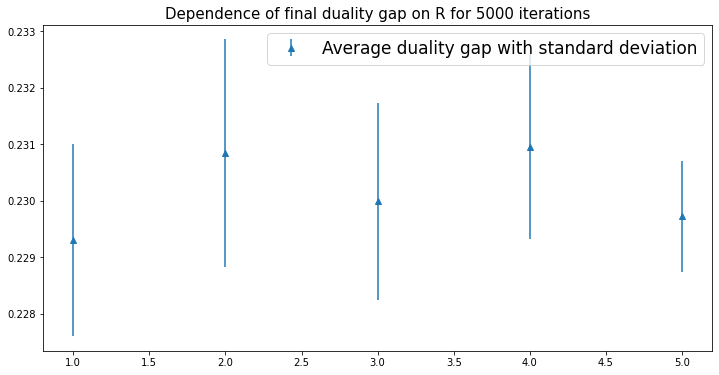

In [215]:
plot1(res1["final_dg_means"], res1["final_dg_stds"])

In [244]:
res2 = dict()
with open("beckmann_results_anton/fwm/exp1_dg_histories.json", "r") as f:
    for line in f:
        res = json.loads(line)
        res2[list(res.keys())[0]] = res[list(res.keys())[0]]

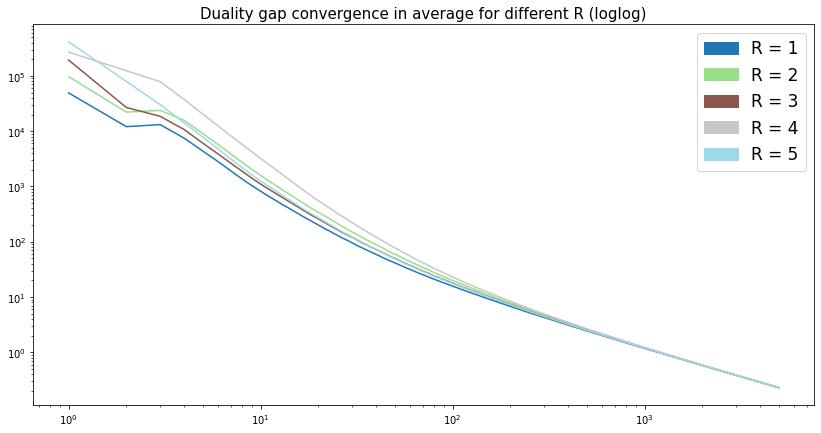

In [217]:
plot2(res2)

# Universal Similar Triangles

### Experiment

In [ ]:
beckmann_save = 'beckmann_results_anton/'
solver = "ustm"
MAX_ITER = 5000
R_list = [1, 2, 3, 4, 5]
nruns = 10

In [ ]:
%%time

model = md.Model(graph_data, graph_correspondences, 
                    total_od_flow, mu = 0.25, rho = 0.15)

solver_kwargs = {'eps_abs': None,
                 'max_iter': MAX_ITER, 'stop_crit': 'max_iter',
                 'verbose' : False, 'save_history' : True}

res = run_experiment_1(model, solver, solver_kwargs, R_list, nruns, beckmann_save, composite=True)

### Graphs

In [220]:
res1 = {"final_dg_means": [], "final_dg_stds": []}

with open("beckmann_results_anton/ustm/exp1_final_dg_means.json", "r") as f:
    for line in f:
        res = json.loads(line)
        res1["final_dg_means"].append(res)

with open("beckmann_results_anton/ustm/exp1_final_dg_stds.json", "r") as f:
    for line in f:
        res = json.loads(line)
        res1["final_dg_stds"].append(res)

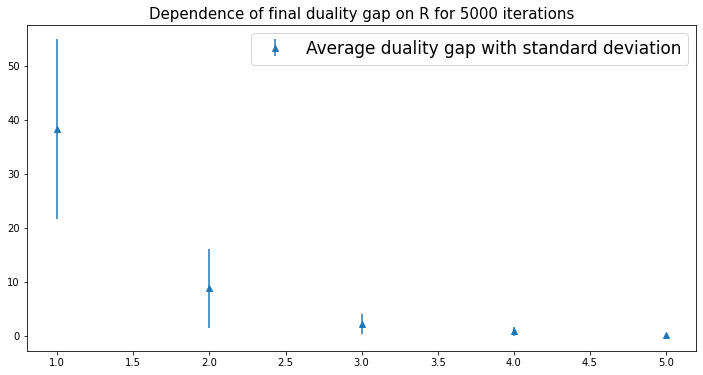

In [221]:
plot1(res1["final_dg_means"], res1["final_dg_stds"])

In [222]:
res2 = dict()
with open("beckmann_results_anton/ustm/exp1_dg_histories.json", "r") as f:
    for line in f:
        res = json.loads(line)
        res2[list(res.keys())[0]] = res[list(res.keys())[0]]

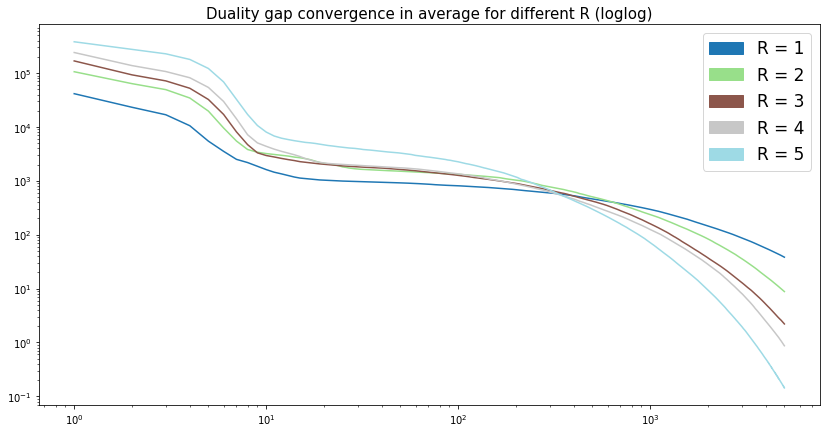

In [223]:
plot2(res2)

# Universal Gradient Descent

### Experiment

In [ ]:
beckmann_save = 'beckmann_results_anton/'
solver = "ugd"
MAX_ITER = 10000
R_list = [1, 2, 3, 4, 5]
nruns = 10

In [ ]:
%%time

model = md.Model(graph_data, graph_correspondences, 
                    total_od_flow, mu = 0.25, rho = 0.15)

solver_kwargs = {'eps_abs': None,
                    'max_iter': MAX_ITER, 'stop_crit': 'max_iter',
                    'verbose' : False, 'save_history' : True}

res = run_experiment_1(model, solver, solver_kwargs, R_list, nruns, beckmann_save, composite=True)

### Graphs

In [227]:
res1 = {"final_dg_means": [], "final_dg_stds": []}

with open("beckmann_results_anton/ugd/exp1_final_dg_means.json", "r") as f:
    for line in f:
        res = json.loads(line)
        res1["final_dg_means"].append(res)

with open("beckmann_results_anton/ugd/exp1_final_dg_stds.json", "r") as f:
    for line in f:
        res = json.loads(line)
        res1["final_dg_stds"].append(res)

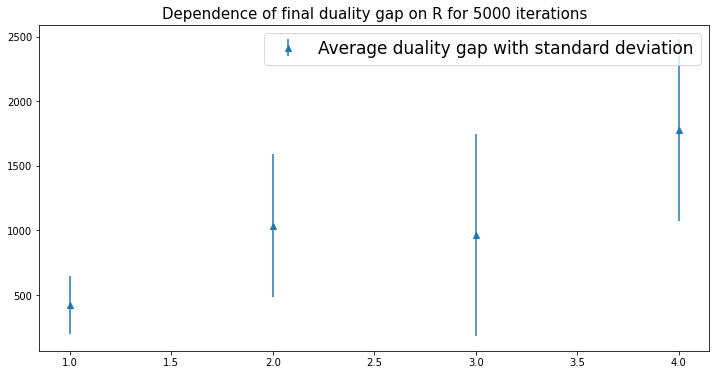

In [228]:
plot1(res1["final_dg_means"], res1["final_dg_stds"])

In [229]:
res2 = dict()
with open("beckmann_results_anton/ugd/exp1_dg_histories.json", "r") as f:
    for line in f:
        res = json.loads(line)
        res2[list(res.keys())[0]] = res[list(res.keys())[0]]

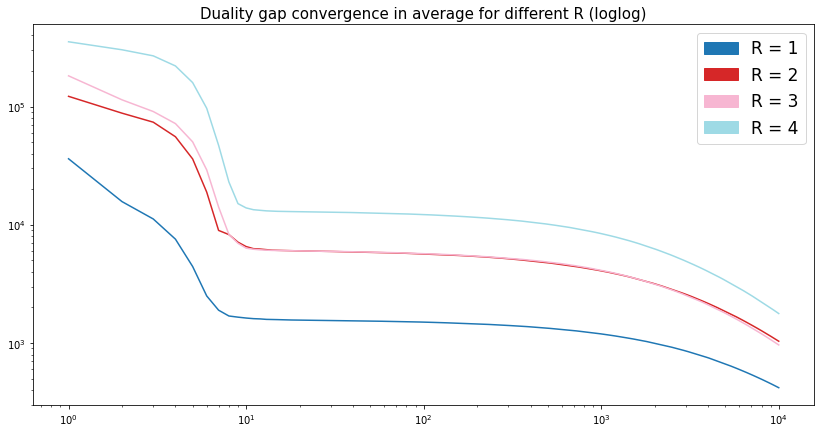

In [230]:
plot2(res2)

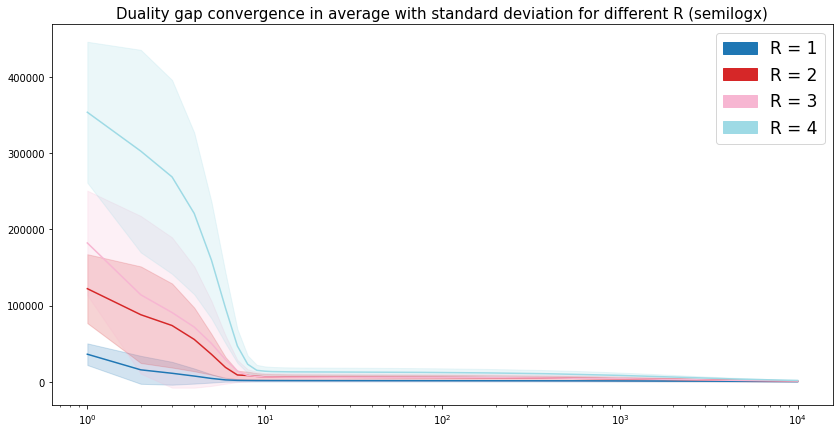

In [232]:
plot3(res2)

# Methods comparison

In [247]:
all_res = {"fwm": {}, "ustm": {}, "ugd": {}}
for method in ["fwm", "ustm", "ugd"]:
    with open(beckmann_save+method+"/exp1_dg_histories.json", "r") as f:
        for i, line in enumerate(f):
            if i == 4:
                continue
            res = json.loads(line)
            all_res[method][list(res.keys())[0]] = res[list(res.keys())[0]]

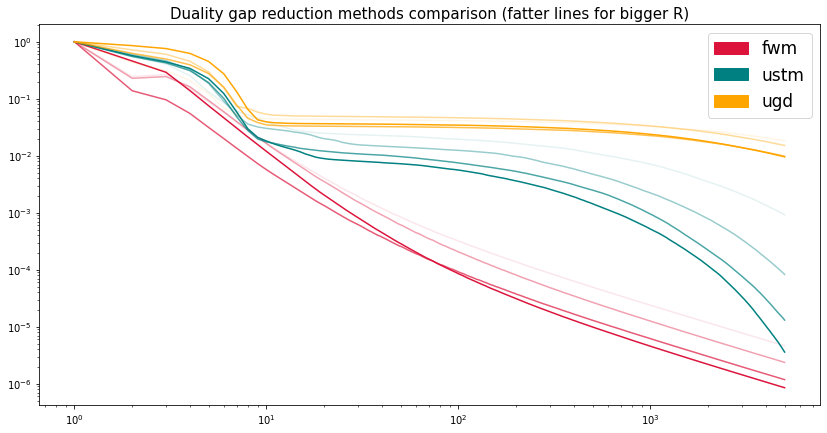

In [248]:
plot4(all_res)

# Conclusion

For Beckman model 3 methods were researched for duality gap reduction in **average**. As a result, Frank-Wolfe method seems to be stable for choosing starting point in average, Universal Gradient Descent suffer from far from solution starting points and Universal Similar Triangles method showed phenomenal results: for more distant from solution starting points it showed better result. Phenomenon could be explained by averaging of trajectories and lack of iterations.